In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np 
import pandas as pd 
import os 
import cv2
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
# Pass the config dictionary when you initialize W&B
config = {
    
    #convolutional layers 
    "conv_1_filters":16, 
    "conv_1_kernel":(5,5),

    "conv_2_filters":32, 
    "conv_2_kernel":(5,5),

    "conv_3_filters":64, 
    "conv_3_kernel":(5,5),

    #pooling layer parameters 
    "pool_size": 3,

    #dense layer parameters
    "dense_1": 1024,
    "dense_2": 512,
    "dense_3": 512,
    "dropout": 0.2,

    #training parameters 
    "batch_size": 128,
    "optimizer": "adam",
    "activation": "relu",
    "learning_rate": 0.0001,
    "epochs": 15

}

wandb.init(project="501_final_version", config=config)

In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/covid_training'


CLASSES = ['COVID', 'non_COVID']

img_height = 300
img_width = 300
batch_size = config['batch_size']


#import data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# #visualize data
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(CLASSES[labels[i]])
#         plt.axis("off")
  

class_names = train_ds.class_names
print(class_names)
print(val_ds)

In [ ]:
# make model for image classification
model = Sequential()
model.add(Conv2D(config['conv_1_filters'], config['conv_1_kernel'], activation=config['activation'], input_shape=(img_height, img_width, 3)))
model.add(MaxPool2D(config['pool_size'], config['pool_size']))
model.add(Conv2D(config['conv_2_filters'], config['conv_2_kernel'], activation=config['activation']))
model.add(MaxPool2D(config['pool_size'], config['pool_size']))
model.add(Conv2D(config['conv_3_filters'], config['conv_3_kernel'], activation=config['activation']))
model.add(MaxPool2D(config['pool_size'], config['pool_size']))

model.add(Flatten())
model.add(Dense(config['dense_1'], activation=config['activation']))
model.add(Dense(config['dense_2'], activation=config['activation']))
model.add(Dense(config['dense_3'], activation=config['activation']))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate = config['learning_rate'])

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


model.summary()

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config['epochs'],
    callbacks=[WandbMetricsLogger()]
) 

wandb.finish()

2/2 [==============================] - 1s 23ms/step


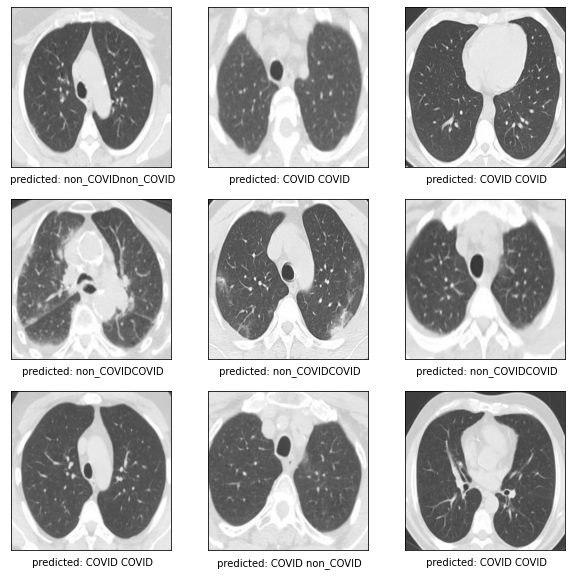

In [ ]:
#make predictions on vlaidation data
val_images, val_labels = next(iter(val_ds))
val_pred = model.predict(val_images)

#plot images and predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_images[i].numpy().astype("uint8"))
    if val_pred[i] > 0.5:
      plt.xlabel(' predicted: COVID, Actual: ' + CLASSES[labels[i]])
    else:
      plt.xlabel(' predicted: non_COVID, Actual: '+ CLASSES[labels[i]])
plt.show()